In [1]:
import numpy as np
import pandas as pd
import implicit
from scipy.sparse import coo_matrix, csr_matrix
from implicit.evaluation import train_test_split, mean_average_precision_at_k,  precision_at_k, AUC_at_k, ndcg_at_k, ranking_metrics_at_k
from implicit.datasets.lastfm import get_lastfm
from implicit.datasets.movielens import get_movielens

In [2]:
#artists, users, plays = get_lastfm()
movies1, ratings1 = get_movielens("1M")
#movies20, ratings20 = get_movielens("20M")

In [44]:
def avg_items(csr):
    user = np.unique(csr.tocoo().row)
    num_items = []
    for u in user :
        num_items.append(len(csr[u].data))
    return pd.Series(num_items)

In [45]:
num_items_M1 = avg_items(ratings1)
num_items_M20 = avg_items(ratings20)
num_items_Lfm = avg_items(plays)

fig, ax = plt.subplots(1, 3)
num_items_M1.hist(bins=30, ax=ax[0], figsize=(20, 6))
num_items_M20.hist(bins=30, ax=ax[1], figsize=(20, 6))
num_items_Lfm.hist(bins=30, ax=ax[2], figsize=(20, 6))

In [ ]:
fig, ax = plt.subplots(1, 3)
num_items_M1.box(bins=30, ax=ax[0], figsize=(20, 6))
num_items_M20.box(bins=30, ax=ax[1], figsize=(20, 6))
num_items_Lfm.box(bins=30, ax=ax[2], figsize=(20, 6))

In [3]:
ratings1_t = ratings1.T

In [359]:
ratings20_t = ratings20.T

In [4]:
train, test = train_test_split(ratings1_t, train_percentage=0.8)

In [172]:
from implicit.als import AlternatingLeastSquares

In [5]:
model = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.1, iterations=15, alpha=20, use_native=True, calculate_training_loss=True)
model.fit(train)

100%|██████████| 15/15 [00:03<00:00,  4.03it/s, loss=0.0439]


In [6]:
model

In [7]:
eval = ranking_metrics_at_k(model, train, test, 10)

100%|██████████| 6036/6036 [00:00<00:00, 10776.18it/s]


In [8]:
eval

{'precision': 0.21245749729103613,
 'map': 0.09926606766243018,
 'ndcg': 0.20649873801508647,
 'auc': 0.5567310197050357}

In [58]:
# MPR per user and mpr complete function
def mpr_per_user(model, train, test, num_recs, user):
    recommended_items = model.recommend(user_items=train[user], userid=user, filter_already_liked_items=True, N = num_recs)[0]
    test_items = test[user].nonzero()[1]
    test_items_in_list = test_items[np.isin(test_items, recommended_items)]
    if len(test_items_in_list) == 0:
        return 0.5
    recommended_indices = recommended_items.argsort()
    hit_indices = recommended_indices[np.searchsorted(recommended_items[recommended_indices], test_items_in_list)]
    #return (np.sum(hit_indices) / num_recs) / len(hit_indices)
    return np.mean(hit_indices / num_recs)

def calc_mpr(model, train, test, full_csr):
    mprs = []
    for u in range(full_csr.shape[0]) :
        mpr = mpr_per_user(model, train, test, full_csr.shape[1], u)
        mprs.append(mpr)
    return {'mpr' : np.mean(mprs)} 

# integrated evaluation function with all metrics, can be extended
def evaluate_model(model, train, test, k, user_item_csr):
    metrics = ranking_metrics_at_k(model, train, test, K=k)
    mpr = calc_mpr(model, train, test, user_item_csr)
    metrics.update(mpr)
    return pd.DataFrame(metrics, index=[str(k)])  

In [59]:
import scipy.sparse as sp

In [147]:
# func to split a csr matrix in k disjoint test/train sets
def split_k_fold(csr_matrix, k) :
    split_matrix = csr_matrix
    return_dict = {}
    return_dict_train = {}
    for i in range(k-1):
        train_temp, test_temp = train_test_split(split_matrix, train_percentage=((k-(i+1))/(k-i)))
        return_dict[str(i)] = test_temp
        if i == 0:
            return_dict_train[str(i)] = train_temp
            rest = test_temp
        else:
            return_dict_train[str(i)] = (train_temp + rest)
            rest = (rest + test_temp)
        if i == (k-2):
            return_dict[str(i+1)] = train_temp
            return_dict_train[str(i+1)] = rest
        split_matrix = train_temp
    return (return_dict, return_dict_train)

# func to process the output of split_k_fold() and perform crossval
def k_fold_eval(test, train) :
    for i in range(len(test)) :
        model = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.1, iterations=15)
        test_temp = test[str(i)]
        train_temp = train[str(i)]
        print(test_temp.nnz)
        print(train_temp.nnz)
        model.fit(train_temp)
        m = evaluate_model(model, train_temp, test_temp, 10, ratings1_t)
        if i == 0:
            df = m
        else :
            df = pd.concat((df, m), axis=0)
    return df

In [148]:
test, train = split_k_fold(ratings1_t, 5)

In [152]:
test_kfold_eval = k_fold_eval(test, train)

  0%|          | 0/15 [00:00<?, ?it/s]

200377
799832


  0%|          | 0/15 [00:00<?, ?it/s]

200059
800150


  0%|          | 0/15 [00:00<?, ?it/s]

200381
799828


  0%|          | 0/15 [00:00<?, ?it/s]

199862
800347


  0%|          | 0/15 [00:00<?, ?it/s]

199530
800679


100%|██████████| 6037/6037 [00:00<00:00, 10352.75it/s]


In [153]:
test_kfold_eval

,precision,map,ndcg,auc,mpr
10,0.401828,0.263530,0.403257,0.585966,0.082422
10,0.398842,0.259468,0.399151,0.584908,0.082460
10,0.398316,0.259047,0.399804,0.585288,0.080818
10,0.396888,0.260285,0.399274,0.584229,0.080790
10,0.399899,0.263167,0.401504,0.585790,0.081580


In [154]:
from cv_py import CrossValidation

In [349]:
ratings1_t.nnz / (ratings1_t.shape[0] * ratings1_t.shape[1])

0.041884670955570365

In [350]:
alpha = (ratings1_t.shape[0] * ratings1_t.shape[1] - ratings1_t.nnz) / sum(ratings1_t.data)

In [355]:
from implicit.lmf import LogisticMatrixFactorization

In [356]:
model = LogisticMatrixFactorization(factors=64, regularization=1.5, iterations=15)
model.fit(train * alpha)

100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


In [26]:
metrics = ranking_metrics_at_k(model, train, test, K=10)
metrics

100%|██████████| 104540/104540 [01:20<00:00, 1299.97it/s]


{'precision': 0.000681690808760131,
 'map': 8.479931734188462e-05,
 'ndcg': 0.0002605321096943011,
 'auc': 0.5000277321471673}

In [28]:
from implicit.datasets.movielens import get_movielens

In [67]:
movies, ratings = get_movielens("1M")

<AxesSubplot:>

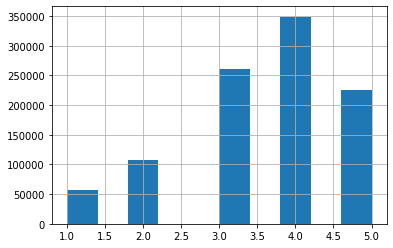

In [68]:
pd.Series(ratings.data).hist()

In [60]:
(ratings.nnz / (ratings.shape[0] * ratings.shape[1]))

0.0011001766467592566

In [61]:
1 - (ratings.nnz / (ratings.shape[0] * ratings.shape[1]))

0.9988998233532408

In [44]:
alpha = (ratings.shape[0] * ratings.shape[1] - ratings.nnz) / sum(ratings.data)

In [45]:
train, test = implicit.evaluation.train_test_split(ratings)

In [46]:
model = LogisticMatrixFactorization(factors=64, regularization=1.5, iterations=15)

In [47]:
model.fit(train)

100%|██████████| 15/15 [02:13<00:00,  8.89s/it]


In [48]:
metrics = ranking_metrics_at_k(model, train, test, K=10)
metrics

100%|██████████| 20290/20290 [00:06<00:00, 3025.87it/s]


{'precision': 0.06749951578539609,
 'map': 0.026425281779652462,
 'ndcg': 0.05743384889302971,
 'auc': 0.513907392739112}

In [1]:
metrics_new = ranking_metrics_at_k(model, train, test, K=5)

NameError: name 'ranking_metrics_at_k' is not defined